# Log Tables

使用 `wandb.Table` 记录数据，以便使用W&B可视化和查询。在本指南中，了解如何：

- Create Tables
- Add Data
- Retrieve Data
- Save Tables

## Create Tables

要定义 Table，请为每行数据指定要查看的列。每行可能是训练数据集中的单个项目，训练期间的特定 step 或 epoch，模型对测试项所做的预测，模型生成的对象等。每列都有固定类型：数字、文本、布尔值、图像、视频、音频等。您无需提前指定类型——只需为每列命名，并确保仅将该类型的数据传递到该列索引中。

通过以下两种方式之一使用 `wandb.Table` 构造函数：

- List of Rows: 记录命名的数据列和行。例如： `wandb.Table(columns=["a", "b", "c"], data=[["1a", "1b", "1c"], ["2a", "2b", "2c"]])` 生成一个两行三列的表
- Pandas DataFrame:  使用 `wandb.Table(dataframe=my_df)` 记录DataFrame。列名将从DataFrame中提取。


```python
my_data = [
    [0, wandb.Image("img_0.jpg"), 0, 0],
    [1, wandb.Image("img_1.jpg"), 8, 0],
    [2, wandb.Image("img_2.jpg"), 7, 1],
    [3, wandb.Image("img_3.jpg"), 1, 1]
]

columns = ["id", "image", "prediction", "truth"]
test_table = wandb.Table(data=my_data, columns=columns)
```

## Add Data

表是可变的，随着脚本的执行，您可以向表中添加更多数据，最多20万行。有两种方法可以将数据添加到表中：

- Add a Row: `table.add_data("3a", "3b", "3c")`。 请注意，新行不表示为列表。如果您的行是列表格式，请使用星号将列表扩展到位置参数：`table.add_data(*my_row_list)`。 该行必须包含与表中列相同的条目数量。
- Add a Column: `table.add_column(name="col_name", data=col_data)`。 注意 `col_data` 的长度必须等于表当前的行数。 `col_data` 可以是一个列表大数据或者 Numpy NDArray。

```python
columns = ["id", "image", "guess", "truth"]
for digit in range(10):
    columns.append("score_" + str(digit))
test_table = wandb.Table(columns=columns)

for img_id, img in enumerate(mnist_test_data):
    true_label = mnist_test_data_labels[img_id]
    guess_label = my_model.predict(img)
    test_table.add_data(img_id, wandb.Image(img), guess_label, true_label)
```

## Retrieve Data

一旦数据进入表中，请按列或行访问：

- **Row Iterator**: 用户可以使用表的行迭代器，例如 `for ndx，row in table.iterrows():...` 来高效地迭代数据的行。
- **Get a Column**: 用户可以使用 `table.get_column("col_name")` 检索一列数据。为了方便起见，用户可以传递 `convert_to="numpy"`，将列转换为 Numpy NDArray。如果您的列包含 `wandb.Image` 等媒体类型，以便您可以直接访问基础数据，这将非常有用。

## Save Tables

在脚本中生成数据表（例如模型预测表）后，将其保存到 W&B 以实时可视化结果。如果您想保存和版本更大的数据集，请查看 Artifact Tables。

### Log a table to a run

使用 `wandb.log()` 将您的表保存到 run 中，如下所示：

```python
run = wandb.init()
my_table = wandb.Table(columns=["a", "b"], data=[["1a", "1b"], ["2a", "2b"]])
run.log({"table_key": my_table})
```

每次将表记录到同一密钥时，都会创建一个新版本的表并将其存储在后端。这意味着您可以在多个训练步骤中记录相同的表，以查看模型预测如何随着时间的推移而改进，或者比较不同运行的表，只要它们记录到相同的键。您最多可以记录20万行。

> 要记录超过200,000行，您可以使用以下内容覆盖限制：`wandb.Table.MAX_ROWS =  X` 。 然而，这可能会导致用户界面中的性能问题，例如查询速度较慢。


### Access tables programmatically

在后端，Tables 作为 Artifacts 保持不变。如果您有兴趣访问特定版本，您可以通过工件API进行访问：

```python
with wandb.init() as run:
   my_table = run.use_artifact("run-<run-id>-<table-name>:<tag>").get("<table-name>")
```

## Visualize tables

以这种方式记录的任何表都将显示在 Run 页面和 Project 页面上的工作区中。

## Advanced: Artifact Tables

使用 `artifact.add()` 将表记录到 run 的 Artifacts 部分，而不是工作区。如果您有一个数据集，您想记录一次，然后参考未来的 runs，这可能会很有用。

```python
run = wandb.init(project="my_project")
test_predictions = wandb.Artifact("mnist_test_preds", type="predictions")
test_table = wandb.Table(data=data, columns=columns)
test_predictions.add(test_table, "my_test_key")
run.log_artifact(test_predictions)
```

## Join Artifact Tables

您可以使用 `wandb.JoinedTable(table_1、table_2、join_key)` 连接本地构建的表或从其他 artifacts 中检索的表。

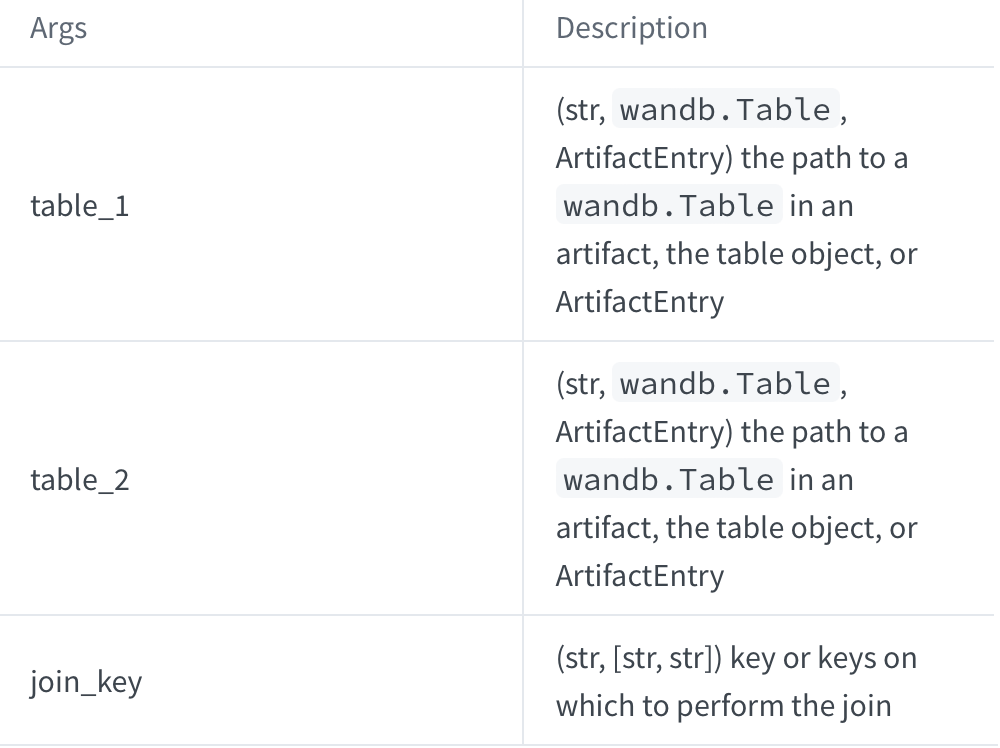


要加入您之前在 artifact 上下文中 log 的两个表，请从 artifact 中获取它们，并将结果加入到新表中。例如，读取一个 Table of original songs 和 另一个  Table of synthesized versions of the same songs，加入“song_id”，然后上传一个新的表进行探索。

```python
run = wandb.init(project="my_project")

orig_songs = run.use_artifact('original_songs: latest')
orig_table = orig_songs.get("original_samples")

synth_songs = run.use_artifact('synth_songs:latest') 
synth_table = synth_songs.get("synth_samples")


join_table = wandb.JoinedTable(orig_table, synth_table "song_id")
join_at = wandb.Artifact("synth_summary", "analysis")

join_at.add(join_table, "synth_explore")
run.log_artifact(join_at)
```